### Descripción

- En esta sesión trabajaremos con una serie de base de datos sobre letras musicales de distintos artistas. Cada uno de los csv se encuentra en la carpeta dump.
- Cada csv tiene el nombre del artista a analizar. Los archivos contienen el nombre del artista, el género musical del artista, el nombre de la canción y las letras.
- En base a esta información, el objetivo del ejercicio es generar un modelo probabilístico que pueda identificar el género musical más probable dado la letra de una canción.
- Para ello implementaremos un modelo conocido como _Latent Dirichlet Allocation_ que hace uso de una variante del algoritmo EM para inferir clases latentes a partir de una matriz de documentos.

### Ejercicio 1: Preparar el ambiente de trabajo

- Importe los módulos numpy , pandas , matplotlib , seaborn , glob y os siguiendo las buenas prácticas. Los últimos dos módulos permitirán realizar la importación de múltiples archivos dentro de la carpeta dump .
- Para ello genere un objeto que guarde en una lista todos los archivos alojados en dump utilizando glob.glob y os.getcwd() para extraer las rutas absolutas. Posteriormente genere un objeto pd.DataFrame que contenga todos los csv.
- Asegúrese de eliminar la columna Unnamed: 0 que se genera por defecto.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

import warnings
warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
file_list = glob.glob(os.getcwd()+ "/dump_plus_pop/*.csv")

# Leer archivos en ruta dump

li = []

for filename in file_list:
    df_file = pd.read_csv(filename, index_col=0)
    li.append(df_file)

df_lyrics = pd.concat(li, ignore_index=True)
df_lyrics.columns = ["artist", "genre", "song", "lyrics"]
display(df_lyrics.head())

artist   genre                    song  \
0  Public Enemy  hiphop  You're Gonna Get Yours   
1  Public Enemy  hiphop     Sophisticated Bitch   
2  Public Enemy  hiphop      Miuzi Weighs A Ton   
3  Public Enemy  hiphop                Timebomb   
4  Public Enemy  hiphop          Too Much Posse   

                                              lyrics  
0  (Flavor Flav) \n Oh-oh Chuck, they out to get ...  
1  That woman in the corner, cold playin' the rol...  
2  Yo Chuck, run a power move on them \n (Yeah) \...  
3  (Intro - Flavor Flav) \n Hey, Chuck, we got so...  
4  (Intro - Flavor Flav) \n What do you got to sa...

### Ejercicio 2: Matriz de ocurrencias
- Importe la clase CountVectorizer dentro de los módulos _feature_extraction.text_ de la librería sklearn.
- Aplique la clase para extraer las 5000 palabras más repetidas en toda la base de datos.
- Con la clase inicializada, incorpore las letras con el método fit_transform y guarde los resultados en un nuevo objeto

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
counter = CountVectorizer(stop_words='english',  max_features=5000, ngram_range=(1,2)) 

counter_fit = counter.fit(df_lyrics['lyrics'].values)
transformed_feats = counter_fit.transform(df_lyrics['lyrics'].values)
transformed_feats

<10804x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 829798 stored elements in Compressed Sparse Row format>

### Ejercicio 3: Entrenamiento del Modelo

- Importe sklearn.decomposition.LatentDirichletAllocation y sklearn.model_selection.GridSearchCV .
- Genere una búsqueda de grilla con los siguientes hiperparámetros: 
 * n_components: [5, 10, 15]. 
 * learning_decay: [0.7, 0.5] .
- Entrene la búsqueda de grilla con las letras en un formato vectorizado con CountVectorizer .
- Reporte brevemente cuál es la mejor combinación de hiperparámetros.

In [5]:
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.model_selection import GridSearchCV

In [6]:
n_componentes =[5,10,15]
learning_decay =[0.7,0.5]

search_params=[{'n_components':n_componentes,
        'learning_decay':learning_decay,
        'learning_method':['online']
        }]

cv_lda_model = GridSearchCV(
        LatentDirichletAllocation (learning_method = 'online'),
        param_grid=search_params, cv=2, n_jobs = -1).fit(transformed_feats)

best_lda = cv_lda_model.best_estimator_
print("Best hyperparams: {}".format(cv_lda_model.best_params_))

Best hyperparams: {'learning_decay': 0.7, 'learning_method': 'online', 'n_components': 5}


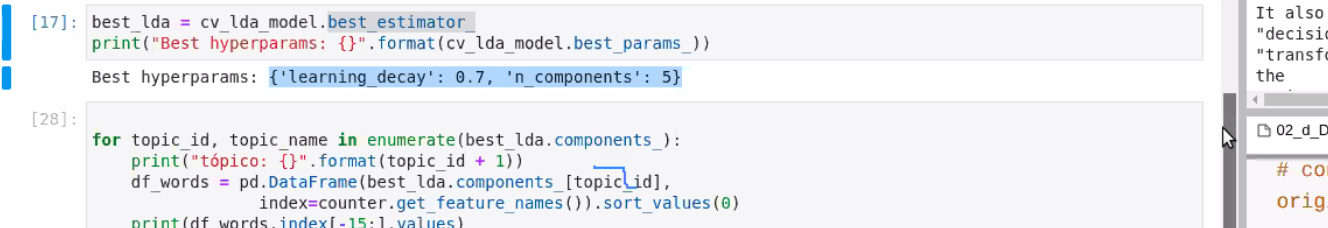

### Ejercicio 4 : Inferencia e Identificación de Tópicos
- En base a la mejor combinación de hiperparámetros, entrene el modelo con la matriz de atributos de las letras.
- Para identificar de qué se trata cada tópico, necesitamos identificar las principales 15 palabras asociadas con éste. Puede implementar la siguiente línea de código para identificar las principales palabras en un tópico:

In [11]:
fit_best_lda = LatentDirichletAllocation(n_components=5, learning_decay=0.5, learning_method='online')
fit_best_lda.fit(transformed_feats);

In [28]:
# mediante .components_ podemos extraer una matriz que entrega las distribución de palabras por cada tópico.
for topic_id, topic_name in enumerate(best_lda.components_):
    # para cada tópico
    print("Tópico: {}".format(topic_id + 1))
    print('-----------')
    # mediante argsort logramos ordenar los elementos por magnitud
    # para los elementos más relevantes ordenados por argsort, buscamos su correlativo
    # en la matriz dispersa y devolvemos el nombre.
    # finalmente concatenamos las palabras
    print(" ".join([counter.get_feature_names()[i] for i in topic_name.argsort()[:-15 - 1: -1]]))

Tópico: 1
-----------
oh yeah don baby know got wanna let want oh oh hey come girl like right
Tópico: 2
-----------
life god world die death blood dead light eyes time soul black man hell night
Tópico: 3
-----------
la rock la la ha tonight dance na ha ha roll da na na christmas come stop girls
Tópico: 4
-----------
love just ll know don ve time way like away say feel make cause heart
Tópico: 5
-----------
like got don ain shit man yo know just cause fuck em nigga ya niggas


Comente a qué tópicos está asociada cada clase inferida.

### Comentarios:

Los tópicos son: 
- Tópico 1: **Pop** 
- Tópico 2: **Metal**
- Tópico 3: **Rock** 
- Tópico 4: **Pop**
- Tópico 5: **Hip-Hop**

### Ejercicio 5: Identificación de probabilidades
- En base a la información generada, es posible identificar cuales van a ser los géneros más probables de ocurrir para un artista.
- Para ello necesitamos guardar la probabilidad de cada canción en nuestra base de datos original. Podemos implementar esto de la siguiente manera:

In [15]:
# generamos una transformación de los datos a distribución de tópico por palabra en el documento
# vector calculado en primera parte
fit_best_lda_trans = fit_best_lda.transform(transformed_feats)
# estra transformación la podemos coercionar a un dataframe de la siguiente manera
topics_for_each_doc = pd.DataFrame(
    # pasamos esta matriz y la redondeamos en 3 decimales
    np.round(fit_best_lda_trans, 3),
    # agregamos un índice
    index=df_lyrics['lyrics'].index
)

# agregamos identificadores de columna
topics_for_each_doc.columns = list(map(lambda x: "T: {}".format(x), range(1, fit_best_lda.n_components + 1)))

# concatenamos las probabilidades de tópico por documento a nuestra matriz original
concatenated_df = pd.concat([df_lyrics['artist'], df_lyrics['lyrics'], topics_for_each_doc], axis=1)

# argmax en la matriz de tópicos
concatenated_df['highest_topic'] = np.argmax(topics_for_each_doc.values, axis=1) + 1 
concatenated_df.sample(10)

artist                                             lyrics  \
5408             Usher  (Intro - J.D.) \n Uh, listen up listen up list...   
1375       Iron Maiden  It's over your head \n And you don't seem to u...   
1327       Iron Maiden  I remember it as plain as day \n Although it h...   
5067  Carly Rae Jepsen  Don't tell me this is how it ends \n I burn wi...   
2669  System of a Down  Poisoning a drink \n Bleeding in a sink \n Cho...   
3919    Britney Spears  Ooh, ooh, ooh, ooh \n Oh, oh, I want you for t...   
4085    Britney Spears  When you gon pull it, \n When you gon pull it,...   
8760            Weezer  Unfortunately, we are not licensed to display ...   
9387   Michael Jackson  Hee! - hee! \n Ooh! \n Go on girl! \n Aaow! \n...   
165       Public Enemy  (Chuck D) \n You may never heard it \n I be sp...   

       T: 1   T: 2   T: 3   T: 4   T: 5  highest_topic  
5408  0.086  0.357  0.080  0.430  0.047              4  
1375  0.832  0.003  0.003  0.158  0.003              1  
1327  0.694  0.068  0.193  0.044  0.002              1  
5067  0.424  0.001  0.200  0.373  0.001              1  
2669  0.693  0.121  0.002  0.182  0.002              1  
3919  0.294  0.002  0.015  0.687  0.002              4  
4085  0.023  0.491  0.001  0.110  0.375              2  
8760  0.009  0.009  0.009  0.009  0.964              5  
9387  0.169  0.001  0.027  0.646  0.158              4  
165   0.437  0.503  0.001  0.041  0.018              2

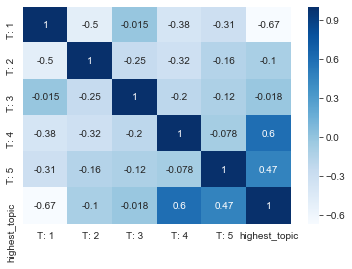

In [16]:
sns.heatmap(concatenated_df.corr(), cmap='Blues', annot=True);

### Comentarios: 
- El tópico que esta mayor correlacionada con la base de datos es el pop (4). Tambien existe una correlacion entre T1 y T4(ambos Pop).

In [33]:
artista = 'Michael Jackson'
concatenated_df[concatenated_df['artist']==artista]['highest_topic'].value_counts('%')

4    0.462366
1    0.397849
3    0.050179
5    0.046595
2    0.043011
Name: highest_topic, dtype: float64

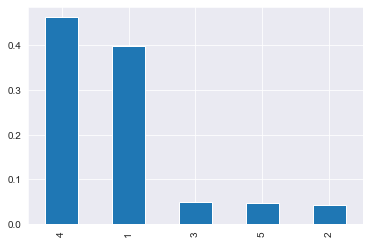

In [38]:
concatenated_df[concatenated_df['artist']==artista]['highest_topic'].value_counts('%').plot(kind='bar')